In [0]:
config = {
    'num_epochs': 20,
    'num_tokens': 2000,
    # 'vocab_size': 10000+4,
    'd_model': 512,
    'num_encoder_layers': 3, # 6
    'num_decoder_layers': 3, # 6
    'dim_feedforward': 2048,
    'nhead': 4, # 8,
    'pos_dropout': 0.2,
    'trans_dropout': 0.2,
    'n_warmup_steps': 4000,
    'batch_size': 64,
}

In [2]:
from google.colab import drive
drive.mount('/content/drive')
root = "drive/My Drive/Colab Notebooks/huawei/project/generations/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pymorphy2
!pip install einops

In [4]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt


from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
from collections import defaultdict
import numpy as np
from einops import rearrange

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.datasets import fetch_20newsgroups

from nltk import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize

import pymorphy2
import re


import os
import time
import json
import tqdm
from bs4 import BeautifulSoup

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")


def save_texts(texts, titles, filename):
  dump_texts = os.path.join(root, filename)
  with open(file=dump_texts, mode='w') as f:
    json.dump({'texts': texts, 'titles': titles}, f)

def load_texts(filename):
  dump_texts = os.path.join(root, filename)
  with open(file=dump_texts, mode='r') as f:
    data = json.load(f)
  return data['texts'], data['titles']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using cuda


# Preprocess ria news

In [0]:
# source_file = "processed-ria.json"
# titles = []
# texts = []

# bad_text = []

# with open(file=os.path.join(root, source_file), mode='r') as f:
#   # lines = f.readlines()[:100]
#   for _ in tqdm.tqdm(range(100000)):
#     line = f.readline()
#     try:
#       line_j = json.loads(line)
#       text = nltk.sent_tokenize(BeautifulSoup(line_j['text'], "lxml").text)[1]
#       titles.append(line_j['title'])
#       texts.append(text)
#     except IndexError:
#       bad_text.append(line_j)

In [0]:
# morph = pymorphy2.MorphAnalyzer()
# pattern = re.compile("^[а-яА-Я]+$")

# texts_processed = []
# titles_processed = []

# def process_sentence(sentence):
#     words = [w for w in nltk.word_tokenize(sentence) if w not in stopwords.words("russian") and pattern.match(w)]
#     words = [morph.parse(word)[0].normal_form for word in words]
#     return words

# for text_i in tqdm.tqdm(range(len(texts))):
#   try:
#     # sentences = nltk.sent_tokenize(texts[text_i])
#     # texts_processed.append(process_sentence(sentences[0]))
#     texts_processed.append(process_sentence(texts[text_i]))
#     titles_processed.append(process_sentence(titles[text_i]))
#   except IndexError as e:
#     print(e)
#     print(text_i)

# texts = texts_processed
# titles = titles_processed
# save_texts(texts, titles)

# Load data

In [7]:
texts, titles = load_texts("ria_text_titles.json") # 
print(len(texts))

98148


275
Read 96153 sentence pairs
Counted words:
ru 55964
[['главарь', 'боевик', 'али', 'тазиев', 'кличка', 'магас', 'задержать', 'северный', 'кавказ', 'сообщить', 'директор', 'фсб', 'россия', 'александр', 'бортник', 'среда', 'встреча', 'президент', 'дмитрий', 'медведев'], ['главарь', 'боевик', 'магас', 'задержать', 'северный', 'кавказ']]
['роджер', 'федерер', 'четыре', 'свой', 'карьера', 'выиграть', 'открытый', 'чемпионат', 'австралия', 'теннис']
['роджер', 'федерер', 'четыре', 'выиграть', 'открытый', 'чемпионат', 'австралия']
275


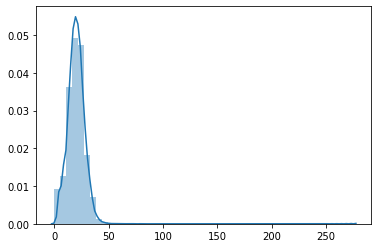

In [8]:
texts, titles = load_texts("ria_text_titles.json") # 98148
# texts, titles = texts[:30000], titles[:30000]
print(max([len(t) for t in texts]))



SOS_token = 0 # start of string.
EOS_token = 1 # end of string.
PAD_token = 2
UNK_token = 3

class Lang: # like a vocabulary
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1, "PAD": PAD_token, 'UNK': UNK_token}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", PAD_token: "PAD", UNK_token: "UNK"}
        self.n_words = len(self.word2index)
        self.max_seq_length = None

    def addSentence(self, sentence):
        if self.max_seq_length is None:
          self.max_seq_length = len(sentence)
        elif self.max_seq_length < len(sentence):
          self.max_seq_length = len(sentence)
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def tensor2text(self, tensor):
        return [self.index2word[token.item()] for token in tensor]
        
    def ids2text(self, numbers):
      return [self.index2word[num] for num in numbers]

    def text2ids(self, tokens):
        return [self.word2index[token] if token in self.word2index else self.word2index['UNK'] for token in tokens]
            
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s



def prepareData(texts, titles):
    pairs = [[txt, ttl] for txt, ttl in zip(texts, titles) if len(txt)>0 and len(ttl)>0 ]
    lang = Lang('ru')

    print("Read %s sentence pairs" % len(pairs))
    for pair in pairs:
        lang.addSentence(pair[0])
        lang.addSentence(pair[1])
    print("Counted words:")
    print(lang.name, lang.n_words)
    return lang, pairs

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(lang, pair[0])
    target_tensor_t = tensorFromSentence(lang, pair[1][:-1])
    target_tensor_l = tensorFromSentence(lang, pair[1])
    return (input_tensor, target_tensor_t, target_tensor_l)


lang, pairs = prepareData(texts, titles)
print(random.choice(pairs))

lens = [len(t) for t in texts]
sns.distplot(lens)

i = 100
print(texts[i])
print(titles[i])
print(lang.max_seq_length)

# Datasets

In [0]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader


class HeadlinesDataset(Dataset):
    def __init__(self, pairs, lang, batch_size):
        self.pairs = pairs
        self.lang = lang
        self.batch_size = batch_size
        self.batch_num = len(self.pairs)//batch_size
        
    def __getitem__(self, index): # todo: make number of pads depend on current batch max text, title length
        srcs = []
        srcs_lns = []
        tgts = []
        tgts_lns = []
        for i in range(self.batch_size):
          src, tgt = self.pairs[index*self.batch_size+i]
          srcs.append(src)
          srcs_lns.append(len(src))
          tgts.append(tgt)
          tgts_lns.append(len(tgt))

        max_src_ln = max(srcs_lns)          
        max_tgt_ln = max(tgts_lns)    

        converted_srcs = []    
        converted_tgts = []    
        srcs_padding_masks = []
        tgts_padding_masks = []

        for i in range(len(srcs)):
          converted_srcs.append(self.lang.text2ids(srcs[i]) + [self.lang.word2index['PAD']]*(max_src_ln-len(srcs[i]))) 
          srcs_padding_masks.append([False]*len(srcs[i]) + [True]*(max_src_ln-len(srcs[i])))

          converted_tgts.append(
              [self.lang.word2index['SOS']] + 
                self.lang.text2ids(tgts[i]) + 
              [self.lang.word2index['EOS']] + 
              [self.lang.word2index['PAD']]*(max_tgt_ln-len(tgts[i]))
              ) 
          tgts_padding_masks.append([False]*(len(tgts[i])+2) + [True]*(max_tgt_ln-len(tgts[i])))

        return (np.array(converted_srcs), np.array(converted_tgts), np.array(srcs_padding_masks), np.array(tgts_padding_masks))

    def __len__(self):
        return self.batch_num


# train_dataset = HeadlinesDataset(pairs[1024:], lang, batch_size=config['batch_size'])
# test_dataset  = HeadlinesDataset(pairs[:1024], lang, batch_size=config['batch_size'])

# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

# src, tgt, src_key_padding_mask, tgt_key_padding_mask =  next(iter(train_loader))
# src, tgt, src_key_padding_mask, tgt_key_padding_mask =  next(iter(test_loader))
# print(src)
# print(tgt)
# print(src_key_padding_mask)
# print(tgt_key_padding_mask)

# Prepear word embeddings

In [0]:
from random import shuffle

union = []
for pair in tqdm.tqdm(pairs):
  union.append(['SOS']+pair[0]+['EOS']+['PAD']+['UNK'])

for pair in tqdm.tqdm(pairs):
  union.append(['SOS']+pair[1]+['EOS']+['PAD']+['UNK'])

shuffle(union)


from gensim.models.word2vec import Word2Vec
from multiprocessing import cpu_count

model = Word2Vec(union, 
                 min_count = 0, 
                 workers=cpu_count(),
                 size=config['d_model'],
                 window=10,
                 negative=5,
                 iter=10
                )


init_voc = set(lang.word2index.keys())
wv_voc = set(model.wv.vocab.keys())
print(len(wv_voc), len(init_voc))
print(wv_voc - init_voc)
print(init_voc - wv_voc)
# assert(len(init_voc)==len(wv_voc))


word_init_vectors = {}
for w in model.wv.vocab:
    word_init_vectors[w] = model[w].tolist()

100%|██████████| 96153/96153 [00:00<00:00, 270177.06it/s]


# Model

In [0]:
import math 
# Source: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=200):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr


def gen_nopeek_mask(length):
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [0]:
class LanguageTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_seq_length, pos_dropout, trans_dropout):
        super().__init__()
        self.d_model = d_model
        self.embed_src = nn.Embedding(vocab_size, d_model)
        self.embed_tgt = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)

        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, trans_dropout)
        self.fc = nn.Linear(d_model, vocab_size)

    def init_embeddings(self, wv):
        assert(self.embed_src.weight.data.shape == wv.shape)
        assert(self.embed_tgt.weight.data.shape == wv.shape)
        self.embed_src.weight.data = wv
        self.embed_tgt.weight.data = wv

    def forward(self, src, tgt, src_key_padding_mask, tgt_key_padding_mask, memory_key_padding_mask, tgt_mask):
        src = src.permute(1, 0)
        tgt = tgt.permute(1, 0)
        src = self.pos_enc(self.embed_src(src) * math.sqrt(self.d_model)) # why every time multiply? just init it somewhere
        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))

        output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
                                  tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        output = output.permute(1, 0, 2)
        return self.fc(output)

In [0]:
# init
model = LanguageTransformer(lang.n_words, config['d_model'], config['nhead'], 
                            config['num_encoder_layers'],config['num_decoder_layers'],
                            config['dim_feedforward'], lang.max_seq_length,
                            config['pos_dropout'], config['trans_dropout'])
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_normal_(p)

wv = torch.Tensor([word_init_vectors[lang.index2word[idx]] for idx in lang.index2word.keys()])
model.init_embeddings(wv)

model.to(device)
# optimizer = Adam(model.parameters(), lr=0.0001)
# optimizer = Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09)
optimizer = ScheduledOptim(
    Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09),
    config['d_model'], config['n_warmup_steps'])

criterion = nn.CrossEntropyLoss(ignore_index=lang.word2index['PAD'])
train_losses = []
test_losses = []

In [0]:
# train
epochs = 10

train_dataset = HeadlinesDataset(pairs[10000:], lang, batch_size=config['batch_size'])
test_dataset  = HeadlinesDataset(pairs[:10000], lang, batch_size=config['batch_size'])

for epoch_i in range(epochs):
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)
    
    train_loss = 0
    model.train()
    for src, tgt, src_key_padding_mask, tgt_key_padding_mask in tqdm.tqdm(iter(train_loader)):
    # for src, tgt, src_key_padding_mask, tgt_key_padding_mask in iter(train_loader):
        src, src_key_padding_mask = src[0].to(device), src_key_padding_mask[0].to(device) # to device
        tgt, tgt_key_padding_mask = tgt[0].to(device), tgt_key_padding_mask[0].to(device) # to device
        memory_key_padding_mask = src_key_padding_mask.clone()
        tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
        tgt_key_padding_mask_inp = tgt_key_padding_mask[:, :-1]
        tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device) # also to device

        optimizer.zero_grad()
        output = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
        loss = criterion(rearrange(output, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))
        loss.backward()
        # optimizer.step()
        optimizer.step_and_update_lr()
        train_loss += loss.item()
    train_losses.append((epoch_i, train_loss))


    test_loss = 0
    model.eval()
    for src, tgt, src_key_padding_mask, tgt_key_padding_mask in tqdm.tqdm(iter(test_loader)):
    # for src, tgt, src_key_padding_mask, tgt_key_padding_mask in iter(test_loader):
        with torch.no_grad():
            src, src_key_padding_mask = src[0].to(device), src_key_padding_mask[0].to(device) # to device
            tgt, tgt_key_padding_mask = tgt[0].to(device), tgt_key_padding_mask[0].to(device) # to device
            memory_key_padding_mask = src_key_padding_mask.clone()
            tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
            tgt_key_padding_mask_inp = tgt_key_padding_mask[:, :-1]
            tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device) # also to device

            output = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
            loss = criterion(rearrange(output, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))
            test_loss += loss.item()
    test_losses.append((epoch_i, test_loss))

    print(f"\nEpoch: {epoch_i} Train loss: {train_loss} Test loss: {test_loss}")
    # break

In [15]:
print(train_losses)
print(test_losses)

[(0, 10277.298031806946)]
[(0, 1002.5683012008667)]


# Inference

In [80]:
src, tgt, src_key_padding_mask, tgt_key_padding_mask =  next(iter(train_loader))
# print(src.shape)
# print(tgt.shape)
# print(src_key_padding_mask.shape)
# print(tgt_key_padding_mask.shape)
# print()

text_i = 3
src, src_key_padding_mask = src[0][text_i:text_i+1].to(device), src_key_padding_mask[0][text_i:text_i+1].to(device) # to device
tgt, tgt_key_padding_mask = tgt[0][text_i:text_i+1].to(device), tgt_key_padding_mask[0][text_i:text_i+1].to(device) # to device
# print(src.shape)
# print(tgt.shape)
# print(src_key_padding_mask.shape)
# print(tgt_key_padding_mask.shape)


def forced_inference(model, src, tgt, src_key_padding_mask, tgt_key_padding_mask):
  # TODO: add accuracy / recall 
  memory_key_padding_mask = src_key_padding_mask.clone()  
  tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
  tgt_key_padding_mask_inp = tgt_key_padding_mask[:, :-1]
  tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device) # also to device
  # print(src.shape)
  # print(tgt_inp.shape)
  # print(tgt_out.shape)
  # print(tgt_key_padding_mask_inp.shape)
  # print(tgt_mask.shape)
  # print()
  output = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
  tokens = torch.argmax(output[0], axis=1)
  return tokens

def greedy_inference(model, src, tgt, src_key_padding_mask, tgt_key_padding_mask, lang):
  memory_key_padding_mask = src_key_padding_mask.clone() 
  tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
  tgt_key_padding_mask_inp = tgt_key_padding_mask[:, :-1]
  tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device) # also to device

  tokens = [tgt_inp[0,0].item()]
  tgt_inp_ = tgt_inp[:]
  
  for tgt_i in range(tgt.shape[1]-1):
    tt = torch.Tensor(tokens)
    tgt_inp_[:, :tt.shape[0]] = tt[:]
    output = model(src, tgt_inp_, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
    next_token = torch.argmax(output[0][tt.shape[0]+1]).item()
    tokens.append(next_token)
    if next_token == lang.word2index['EOS']:
      break

  return torch.Tensor(tokens)

def inference(model, src, tgt, src_key_padding_mask, tgt_key_padding_mask, lang, mode):
  """
  src: Tensor [1, S]
  tgt: Tensor [1, T]
  modes: forced / greedy [/ beam search]
  """
  
  if mode == "forced":
    tokens = forced_inference(model, src, tgt, src_key_padding_mask, tgt_key_padding_mask)
    
  elif mode == "greedy":
    tokens = greedy_inference(model, src, tgt, src_key_padding_mask, tgt_key_padding_mask, lang)

  print(f"Mode: {mode}")
  print(f'Source: {lang.tensor2text(src[0])}')
  print(f'Target: {lang.tensor2text(tgt[0])}')
  print(f'Generated: {lang.tensor2text(tokens)}')


inference(model, src, tgt, src_key_padding_mask, tgt_key_padding_mask, lang, 'forced')
inference(model, src, tgt, src_key_padding_mask, tgt_key_padding_mask, lang, 'greedy')

Source: ['наблюдение', 'квартира', 'который', 'высокий', 'вероятность', 'возникновение', 'пожар', 'планироваться', 'организовать', 'москва', 'рассказать', 'риа', 'новость', 'понедельник', 'источник', 'столичный', 'администрация', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
Target: ['SOS', 'планировать', 'пожар', 'усилить', 'контроль', 'пожароопасный', 'квартира', 'EOS', 'PAD', 'PAD', 'PAD']
Generated: ['SOS', 'планировать', 'пожар', 'EOS']


In [48]:
# failed sanity check

src, tgt, src_key_padding_mask, tgt_key_padding_mask =  next(iter(train_loader))
text_i = 3
src, src_key_padding_mask = src[0][text_i:text_i+1].to(device), src_key_padding_mask[0][text_i:text_i+1].to(device) # to device
tgt, tgt_key_padding_mask = tgt[0][text_i:text_i+1].to(device), tgt_key_padding_mask[0][text_i:text_i+1].to(device) # to device

tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
tgt_key_padding_mask_inp = tgt_key_padding_mask[:, :-1]
tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device) # also to device
print(src.shape)
print(tgt_inp.shape)
print(tgt_out.shape)
print(tgt_key_padding_mask_inp.shape)
print(tgt_mask.shape)
print()

# tgt_key_padding_mask_inp = torch.Tensor([[False]+[True]*(tgt_inp.shape[1]-1)]).bool().to(device)
model.eval()
tgt_mask[:, 1:] = tgt_mask[0, 1] # sanity check
output = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
print(output.shape)
print(output[0, :, 9]) # they should be same

torch.Size([1, 39])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([10, 10])

torch.Size([1, 10, 55964])
tensor([1.6116, 1.7882, 1.5525, 2.7367, 1.1095, 1.6610, 1.4240, 1.8079, 1.9798,
        1.9811], device='cuda:0', grad_fn=<SelectBackward>)


tensor([[2253,  150,  860,  689,  705,  835, 1093, 1728,    1,    2]],
       device='cuda:0')

In [30]:
output = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
print(output)

tensor([[[-7.4522,  0.5211, -7.4363,  ..., -7.5318, -7.4330, -7.4693],
         [-7.1339,  0.4152, -7.1078,  ..., -7.2298, -7.0972, -7.1576],
         [-7.6243,  0.6096, -7.5907,  ..., -7.7260, -7.6079, -7.6481],
         ...,
         [-7.4810,  0.6389, -7.4677,  ..., -7.6108, -7.4503, -7.5029],
         [-7.5305,  0.7622, -7.4795,  ..., -7.6175, -7.4777, -7.5463],
         [-7.6285,  0.4827, -7.5915,  ..., -7.7473, -7.6052, -7.6280]]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [21]:
print(tgt_inp)
print(tgt_key_padding_mask_inp)
print()

tensor([[   0, 2253,  150,  860,  689,  705,  835, 1093, 1728,    1]],
       device='cuda:0')
tensor([[False, False, False, False, False, False, False, False, False, False]],
       device='cuda:0')
tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True]])


In [0]:

loss = criterion(rearrange(output, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))

In [0]:
# inference


src, tgt, src_key_padding_mask, tgt_key_padding_mask =  next(iter(test_loader))
print(src)
print(tgt)
print(src_key_padding_mask)
print(tgt_key_padding_mask)

In [0]:
src_, src_key_padding_mask_ = src[0].to(device), src_key_padding_mask[0].to(device)
tgt_, tgt_key_padding_mask_ = tgt[0].to(device), tgt_key_padding_mask[0].to(device)
memory_key_padding_mask = src_key_padding_mask_.clone()
tgt_inp, tgt_out = tgt_[:, :-1], tgt_[:, 1:]
tgt_key_padding_mask_inp = tgt_key_padding_mask_[:, :-1]
tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device)

IndexError: ignored

In [0]:
print(tgt_key_padding_mask_.shape)
print(src_.shape)
print(tgt_inp.shape)
print(src_key_padding_mask_.shape)
print(memory_key_padding_mask.shape)
print(tgt_mask.shape)

In [0]:
output = model(src_, tgt_inp, src_key_padding_mask_, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)

In [0]:
 torch.isnan(output).any()

In [0]:
src_.shape

In [0]:
src_[0][0]

In [0]:
src[0][9]

In [0]:
lang.tensor2text(tgt[0][9])

In [0]:
for row_i in range(src_.shape[0]):
  print(row_i, src_[row_i][1])

In [0]:
src, src_key_padding_mask = src[0].to(device), src_key_padding_mask[0].to(device) # to device
tgt, tgt_key_padding_mask = tgt[0].to(device), tgt_key_padding_mask[0].to(device) # to device
memory_key_padding_mask = src_key_padding_mask.clone()
tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
tgt_key_padding_mask_inp = tgt_key_padding_mask[:, :-1]
tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device) # also to device

optimizer.zero_grad()
output = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
loss = criterion(rearrange(output, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))
loss.backward()
optimizer.step()
train_loss += loss.item()

In [0]:
output = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
criterion(rearrange(output, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))

In [0]:
src_ = src.permute(1, 0)
tgt_ = tgt_inp.permute(1, 0)
# src_ = model.pos_enc(model.embed_src(src_) * math.sqrt(model.d_model)) # why every time multiply? just init it somewhere
# tgt_ = model.pos_enc(model.embed_tgt(tgt_) * math.sqrt(model.d_model))

In [0]:
src_[:, 0].unsqueeze(0)

In [0]:
print(model.embed_src(src_[:, 0].unsqueeze(0)))

In [0]:
model.embed_src(torch.Tensor([[lang.word2index['PAD']]]).long().to(device) )

In [0]:


output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
                          tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
output = output.permute(1, 0, 2)
return self.fc(output)

In [0]:
output

In [0]:

global_embeddings = nn.Embedding(lang.n_words, config['d_model'])
wv = torch.Tensor([word_init_vectors[lang.index2word[idx]] for idx in lang.index2word.keys()])
global_embeddings.weight.data = wv


criterion = nn.CrossEntropyLoss(ignore_index=lang.word2index['PAD'])

d_model = config['d_model']
pos_dropout = config['pos_dropout']
nhead = config['nhead']
num_encoder_layers = config['num_encoder_layers']
num_decoder_layers = config['num_decoder_layers']
dim_feedforward = config['dim_feedforward']
trans_dropout = config['trans_dropout']



embed_src = global_embeddings
embed_tgt = global_embeddings
pos_enc = PositionalEncoding(d_model, pos_dropout, lang.max_seq_length)
transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, trans_dropout)
fc = nn.Linear(d_model, lang.n_words)

In [0]:
src, tgt, src_key_padding_mask, tgt_key_padding_mask =  next(iter(train_loader))
src, src_key_padding_mask = src[0], src_key_padding_mask[0].to(device) # to device
tgt, tgt_key_padding_mask = tgt[0], tgt_key_padding_mask[0].to(device) # to device
memory_key_padding_mask = src_key_padding_mask.clone()
tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
tgt_key_padding_mask_inp = tgt_key_padding_mask[:, :-1]
tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device) # also to device

print(src.shape)
print(tgt.shape)
print(src_key_padding_mask.shape)
print(tgt_key_padding_mask.shape)
print(tgt_inp.shape)
print(tgt_out.shape)
print(tgt_mask.shape)

In [0]:
src = src.permute(1, 0)
tgt_inp = tgt_inp.permute(1, 0)
src = pos_enc(embed_src(src) * math.sqrt(d_model))
tgt_inp = pos_enc(embed_tgt(tgt_inp) * math.sqrt(d_model))

In [0]:
print(src.shape, tgt_inp.shape)

In [0]:
print(src.shape)
print(tgt_inp.shape)
print(tgt_mask.shape)
print(src_key_padding_mask.shape)
print(tgt_key_padding_mask_inp.shape)
print(memory_key_padding_mask.shape)

In [0]:
output = transformer(src, tgt_inp, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
                          tgt_key_padding_mask=tgt_key_padding_mask_inp, memory_key_padding_mask=memory_key_padding_mask)
output = output.permute(1, 0, 2)
output = fc(output)

In [0]:
loss = criterion(rearrange(output, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))

In [0]:
import math

import torch
from torch import nn


class LanguageTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_seq_length, pos_dropout, trans_dropout):
        super().__init__()
        self.d_model = d_model
        self.embed_src = nn.Embedding(vocab_size, d_model)
        self.embed_tgt = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)

        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, trans_dropout)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt, src_key_padding_mask, tgt_key_padding_mask, memory_key_padding_mask, tgt_mask):
        # src = rearrange(src, 'n s -> s n')
        src = src.permute(1, 0)
        # tgt = rearrange(tgt, 'n t -> t n')
        tgt = tgt.permute(1, 0)
        src = self.pos_enc(self.embed_src(src) * math.sqrt(self.d_model)) # why every time multiply? just init it somewhere
        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))

        output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
                                  tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        # output = rearrange(output, 't n e -> n t e')
        output = output.permute(1, 0, 2)
        return self.fc(output)

In [0]:
        total_step += 1

        src, src_key_padding_mask = src[0].to('cuda'), src_key_padding_mask[0].to('cuda')
        tgt, tgt_key_padding_mask = tgt[0].to('cuda'), tgt_key_padding_mask[0].to('cuda')

        memory_key_padding_mask = src_key_padding_mask.clone()
        tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
        tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to('cuda')

        optim.zero_grad()
        outputs = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask[:, :-1], memory_key_padding_mask, tgt_mask)
        loss = criterion(rearrange(outputs, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))

        loss.backward()
        optim.step_and_update_lr()

        total_loss += loss.item()
        train_losses.append((step, loss.item()))
        pbar.update(1)
        if step % print_every == print_every - 1:
            pbar.close()
            print(f'Epoch [{epoch + 1} / {num_epochs}] \t Step [{step + 1} / {len(train_loader)}] \t '
                  f'Train Loss: {total_loss / print_every}')
            total_loss = 0

            pbar = tqdm(total=print_every, leave=False)

    pbar.close()
    val_loss = validate(valid_loader, model, criterion)
    val_losses.append((total_step, val_loss))
    if val_loss < lowest_val:
        lowest_val = val_loss
        torch.save(model, 'output/transformer.pth')
    print(f'Val Loss: {val_loss}')

In [0]:
import pickle
import random
import numpy as np
from torch.utils.data import Dataset


class ParallelLanguageDataset(Dataset):
    def __init__(self, data_path_1, data_path_2, num_tokens, max_seq_length):
        self.num_tokens = num_tokens
        self.data_1, self.data_2, self.data_lengths = load_data(data_path_1, data_path_2, max_seq_length)

        self.batches = gen_batches(num_tokens, self.data_lengths)

    def __getitem__(self, idx):
        src, src_mask = getitem(idx, self.data_1, self.batches, True)
        tgt, tgt_mask = getitem(idx, self.data_2, self.batches, False)

        return src, src_mask, tgt, tgt_mask

    def __len__(self):
        return len(self.batches)

    def shuffle_batches(self):
        self.batches = gen_batches(self.num_tokens, self.data_lengths)


def gen_batches(num_tokens, data_lengths):
    # Shuffle all the indices
    for k, v in data_lengths.items():
        random.shuffle(v)

    batches = []
    prev_tokens_in_batch = 1e10
    for k in sorted(data_lengths):
        v = data_lengths[k]
        total_tokens = (k[0] + k[1]) * len(v)

        while total_tokens > 0:
            tokens_in_batch = min(total_tokens, num_tokens) - min(total_tokens, num_tokens) % (k[0] + k[1])
            sentences_in_batch = tokens_in_batch // (k[0] + k[1])

            # Combine with previous batch?
            if tokens_in_batch + prev_tokens_in_batch <= num_tokens:
                batches[-1].extend(v[:sentences_in_batch])
                prev_tokens_in_batch += tokens_in_batch
            else:
                batches.append(v[:sentences_in_batch])
                prev_tokens_in_batch = tokens_in_batch
            v = v[sentences_in_batch:]

            total_tokens = (k[0] + k[1]) * len(v)
    return batches


def load_data(data_path_1, data_path_2, max_seq_length):
    with open(data_path_1, 'rb') as f:
        data_1 = pickle.load(f)
    with open(data_path_2, 'rb') as f:
        data_2 = pickle.load(f)

    data_lengths = {}
    for i, (str_1, str_2) in enumerate(zip(data_1, data_2)):
        if 0 < len(str_1) <= max_seq_length and 0 < len(str_2) <= max_seq_length - 2:
            if (len(str_1), len(str_2)) in data_lengths:
                data_lengths[(len(str_1), len(str_2))].append(i)
            else:
                data_lengths[(len(str_1), len(str_2))] = [i]
    return data_1, data_2, data_lengths


def getitem(idx, data, batches, src):
    sentence_indices = batches[idx]
    if src:
        batch = [data[i] for i in sentence_indices]
    else:
        batch = [[2] + data[i] + [3] for i in sentence_indices]

    seq_length = 0
    for sentence in batch:
        if len(sentence) > seq_length:
            seq_length = len(sentence)

    masks = []
    for i, sentence in enumerate(batch):
        masks.append([False for _ in range(len(sentence))] + [True for _ in range(seq_length - len(sentence))])
        batch[i] = sentence + [0 for _ in range(seq_length - len(sentence))]

    return np.array(batch), np.array(masks)

In [0]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr



In [0]:
def train(train_loader, valid_loader, model, optim, criterion, num_epochs):
    print_every = 500
    model.train()

    lowest_val = 1e9
    train_losses = []
    val_losses = []
    total_step = 0
    for epoch in range(num_epochs):
        pbar = tqdm(total=print_every, leave=False)
        total_loss = 0

        train_loader.dataset.shuffle_batches()
        for step, (src, src_key_padding_mask, tgt, tgt_key_padding_mask) in enumerate(iter(train_loader)):
            total_step += 1

            src, src_key_padding_mask = src[0].to('cuda'), src_key_padding_mask[0].to('cuda')
            tgt, tgt_key_padding_mask = tgt[0].to('cuda'), tgt_key_padding_mask[0].to('cuda')

            memory_key_padding_mask = src_key_padding_mask.clone()
            tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
            tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to('cuda')

            optim.zero_grad()
            outputs = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask[:, :-1], memory_key_padding_mask, tgt_mask)
            loss = criterion(rearrange(outputs, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))

            loss.backward()
            optim.step_and_update_lr()

            total_loss += loss.item()
            train_losses.append((step, loss.item()))
            pbar.update(1)
            if step % print_every == print_every - 1:
                pbar.close()
                print(f'Epoch [{epoch + 1} / {num_epochs}] \t Step [{step + 1} / {len(train_loader)}] \t '
                      f'Train Loss: {total_loss / print_every}')
                total_loss = 0

                pbar = tqdm(total=print_every, leave=False)

        pbar.close()
        val_loss = validate(valid_loader, model, criterion)
        val_losses.append((total_step, val_loss))
        if val_loss < lowest_val:
            lowest_val = val_loss
            torch.save(model, 'output/transformer.pth')
        print(f'Val Loss: {val_loss}')
    return train_losses, val_losses


def validate(valid_loader, model, criterion):
    pbar = tqdm(total=len(iter(valid_loader)), leave=False)
    model.eval()

    total_loss = 0
    for src, src_key_padding_mask, tgt, tgt_key_padding_mask in iter(valid_loader):
        with torch.no_grad():
            src, src_key_padding_mask = src[0].to('cuda'), src_key_padding_mask[0].to('cuda')
            tgt, tgt_key_padding_mask = tgt[0].to('cuda'), tgt_key_padding_mask[0].to('cuda')
            memory_key_padding_mask = src_key_padding_mask.clone()
            tgt_inp = tgt[:, :-1]
            tgt_out = tgt[:, 1:].contiguous()
            tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to('cuda')

            outputs = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask[:, :-1], memory_key_padding_mask, tgt_mask)
            loss = criterion(rearrange(outputs, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))

            total_loss += loss.item()
            pbar.update(1)

    pbar.close()
    model.train()
    return total_loss / len(valid_loader)


def gen_nopeek_mask(length):
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [0]:
kwargs = {
    'num_epochs': 20,
    'max_seq_length': 96,
    'num_tokens': 2000,
    'vocab_size': 10000+4,
    'd_model': 512,
    'num_encoder_layers': 6,
    'num_decoder_layers': 6,
    'dim_feedforward': 2048,
    'nhead': 8,
    'pos_dropout': 0.1,
    'trans_dropout': 0.1,
    'n_warmup_steps': 4000
}

In [0]:
train_dataset = ParallelLanguageDataset(root + 'data/processed/en/train.pkl',
                                        root + 'data/processed/fr/train.pkl',
                                        kwargs['num_tokens'], kwargs['max_seq_length'])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
valid_dataset = ParallelLanguageDataset(root + 'data/processed/en/val.pkl',
                                        root + 'data/processed/fr/val.pkl',
                                        kwargs['num_tokens'], kwargs['max_seq_length'])
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

In [0]:
src, src_key_padding_mask, tgt, tgt_key_padding_mask = train_dataset[100]
print(src.shape)
print(tgt.shape)

In [0]:
model = LanguageTransformer(kwargs['vocab_size'], kwargs['d_model'], kwargs['nhead'], kwargs['num_encoder_layers'],
                            kwargs['num_decoder_layers'], kwargs['dim_feedforward'], kwargs['max_seq_length'],
                            kwargs['pos_dropout'], kwargs['trans_dropout']).to('cuda')
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_normal_(p)

optim = ScheduledOptim(
    Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09),
    kwargs['d_model'], kwargs['n_warmup_steps'])

criterion = nn.CrossEntropyLoss(ignore_index=0)

In [0]:
print_every = 500
model.train()

lowest_val = 1e9
train_losses = []
val_losses = []
total_step = 0

In [0]:
# for epoch in range(kwargs['num_epochs']):
epoch = 1

In [0]:
pbar = tqdm(total=print_every, leave=False)
total_loss = 0
train_loader.dataset.shuffle_batches()

# for step, (src, src_key_padding_mask, tgt, tgt_key_padding_mask) in enumerate(iter(train_loader)):
step, (src, src_key_padding_mask, tgt, tgt_key_padding_mask) = next(enumerate(iter(train_loader)))

In [0]:
print(src.shape, tgt.shape)

total_step += 1

src, src_key_padding_mask = src[0].to('cuda'), src_key_padding_mask[0].to('cuda')
tgt, tgt_key_padding_mask = tgt[0].to('cuda'), tgt_key_padding_mask[0].to('cuda')

print(src.shape)
print(tgt.shape)

In [0]:
memory_key_padding_mask = src_key_padding_mask.clone()

In [0]:
tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:] # shift for 1 position

In [0]:
tgt_inp.shape

In [0]:
tgt_out.shape

In [0]:
def gen_nopeek_mask(length):
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

gen_nopeek_mask(tgt_inp.shape[1])

In [0]:
tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to('cuda')

In [0]:
optim.zero_grad()
outputs = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask[:, :-1], memory_key_padding_mask, tgt_mask)
loss = criterion(rearrange(outputs, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))

In [0]:
outputs.shape

In [0]:
rearrange(outputs, 'b t v -> (b t) v').shape

In [0]:
rearrange(tgt_out, 'b o -> (b o)').shape

In [0]:
rearrange(np.array([]))

In [0]:
loss.backward()
optim.step_and_update_lr()

total_loss += loss.item()
train_losses.append((step, loss.item()))
pbar.update(1)
if step % print_every == print_every - 1:
    pbar.close()
    print(f'Epoch [{epoch + 1} / {num_epochs}] \t Step [{step + 1} / {len(train_loader)}] \t '
          f'Train Loss: {total_loss / print_every}')
    total_loss = 0

    pbar = tqdm(total=print_every, leave=False)

In [0]:
pbar.close()
val_loss = validate(valid_loader, model, criterion)
val_losses.append((total_step, val_loss))
if val_loss < lowest_val:
    lowest_val = val_loss
    torch.save(model, 'output/transformer.pth')
print(f'Val Loss: {val_loss}')